In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading Data - EDA - PCA

In [3]:
data=pd.read_csv('features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
X = data.drop(['filename', 'label'], axis=1)
y = data['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
pca = PCA().fit(X_train_scaled)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components selected: {n_components}")

# Transform data using selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_feature_names = [f'PC{i+1}' for i in range(n_components)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_feature_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_feature_names)

Number of components selected: 33


# Model Training

In [13]:
models = {
    'K-NN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(kernel='linear'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
}

### Needed Functions

In [46]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, feature_names=None):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    results = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    
    print(f"\n{classifier.__class__.__name__} Results:")
    print(f"Accuracy: {results['accuracy']}")
    print("Confusion Matrix:")
    print(results['confusion_matrix'])
    print("Classification Report:")
    print(pd.DataFrame(results['classification_report']).transpose())

    if hasattr(classifier, 'feature_importances_') or (hasattr(classifier, 'coef_') and classifier.__class__.__name__ != 'SVC'):
        feature_importances = extract_feature_importance(classifier, feature_names)
        print(f"\n{classifier.__class__.__name__} Feature Importances:")
        print(feature_importances)
        feature_importances.plot(kind='bar', x='Feature', y='Importance', legend=False, title=f"{classifier.__class__.__name__} Feature Importances")
        plt.show()

    return results['accuracy']

def extract_feature_importance(classifier, feature_names):
    if hasattr(classifier, 'feature_importances_'):
        importance = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importance = classifier.coef_[0]
    else:
        raise ValueError('Classifier does not have feature_importances_ or coef_ attribute')

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return feature_importance_df

def plot_accuracies(accuracies):
    df_accuracies = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
    df_accuracies = df_accuracies.sort_values(by='Accuracy', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(df_accuracies['Model'], df_accuracies['Accuracy'], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Model Accuracies')
    plt.xticks(rotation=45)
    plt.show()

# Model Training & Evaluation

In [47]:
accuracies = {}

## KNN

In [48]:
# for model_name, model in models.items():
#     feature_names = X_train_pca_df.columns if model_name in ['Random Forest', 'Gradient Boosting'] else None
#     accuracies[model_name] = evaluate_classifier(model, X_train_pca_df, y_train, X_test_pca_df, y_test, feature_names)

# models = {
#     'K-NN': KNeighborsClassifier(n_neighbors=5),
#     'Random Forest': RandomForestClassifier(n_estimators=100),
#     'SVM': SVC(kernel='linear'),
#     'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
#     'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
# }

accuracies['K-NN']=evaluate_classifier(models['K-NN'],X_train_pca,y_train,X_test_pca,y_test)



KNeighborsClassifier Results:
Accuracy: 0.655
Confusion Matrix:
[[14  0  3  0  0  0  0  0  0  3]
 [ 0 11  0  0  0  2  0  0  0  0]
 [ 2  1 18  1  1  1  0  0  2  1]
 [ 1  0  2 14  1  0  1  1  1  0]
 [ 0  0  0  1 11  0  0  1  2  0]
 [ 1  1  3  1  0 15  0  0  0  1]
 [ 0  0  0  3  0  0 21  0  0  1]
 [ 1  0  0  0  0  1  0 10  1  0]
 [ 0  0  5  3  5  0  1  1  8  0]
 [ 3  0  4  1  0  1  0  2  1  9]]
Classification Report:
              precision    recall  f1-score  support
0              0.636364  0.700000  0.666667   20.000
1              0.846154  0.846154  0.846154   13.000
2              0.514286  0.666667  0.580645   27.000
3              0.583333  0.666667  0.622222   21.000
4              0.611111  0.733333  0.666667   15.000
5              0.750000  0.681818  0.714286   22.000
6              0.913043  0.840000  0.875000   25.000
7              0.666667  0.769231  0.714286   13.000
8              0.533333  0.347826  0.421053   23.000
9              0.600000  0.428571  0.500000   21.00

## Random Forest


RandomForestClassifier Results:
Accuracy: 0.66
Confusion Matrix:
[[13  0  0  0  1  1  4  0  0  1]
 [ 0 12  0  0  0  1  0  0  0  0]
 [ 2  0 18  2  0  0  1  0  2  2]
 [ 1  0  0  9  2  0  2  4  3  0]
 [ 0  0  0  0 13  0  0  1  1  0]
 [ 0  0  1  1  0 18  0  1  0  1]
 [ 1  0  0  1  1  0 21  0  0  1]
 [ 1  0  0  0  0  2  0  8  2  0]
 [ 1  1  1  3  3  0  2  1 10  1]
 [ 1  0  4  2  0  0  2  1  1 10]]
Classification Report:
              precision    recall  f1-score  support
0              0.650000  0.650000  0.650000    20.00
1              0.923077  0.923077  0.923077    13.00
2              0.750000  0.666667  0.705882    27.00
3              0.500000  0.428571  0.461538    21.00
4              0.650000  0.866667  0.742857    15.00
5              0.818182  0.818182  0.818182    22.00
6              0.656250  0.840000  0.736842    25.00
7              0.500000  0.615385  0.551724    13.00
8              0.526316  0.434783  0.476190    23.00
9              0.625000  0.476190  0.540541    21.

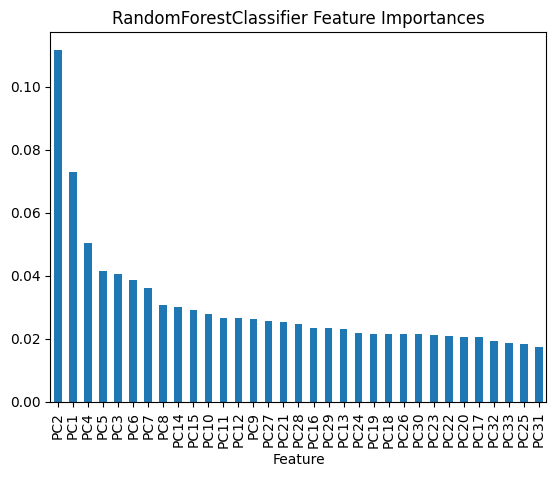

In [49]:
accuracies['Random Forest']=evaluate_classifier(models['Random Forest'], X_train_pca_df,y_train, X_test_pca_df,y_test, X_train_pca_df.columns)

## SVM

In [50]:
accuracies['SVM']=evaluate_classifier(models['SVM'], X_train_pca_df,y_train, X_test_pca_df,y_test)


SVC Results:
Accuracy: 0.675
Confusion Matrix:
[[10  0  1  0  0  1  3  0  2  3]
 [ 0 12  1  0  0  0  0  0  0  0]
 [ 2  0 18  1  1  0  0  0  1  4]
 [ 1  0  1 13  3  0  0  1  1  1]
 [ 1  0  0  1 11  0  0  0  2  0]
 [ 1  1  1  0  0 16  0  1  0  2]
 [ 0  0  0  1  1  0 22  0  0  1]
 [ 0  0  2  0  0  0  0 11  0  0]
 [ 1  0  3  0  4  0  2  0 12  1]
 [ 3  0  3  3  1  0  1  0  0 10]]
Classification Report:
              precision    recall  f1-score  support
0              0.526316  0.500000  0.512821   20.000
1              0.923077  0.923077  0.923077   13.000
2              0.600000  0.666667  0.631579   27.000
3              0.684211  0.619048  0.650000   21.000
4              0.523810  0.733333  0.611111   15.000
5              0.941176  0.727273  0.820513   22.000
6              0.785714  0.880000  0.830189   25.000
7              0.846154  0.846154  0.846154   13.000
8              0.666667  0.521739  0.585366   23.000
9              0.454545  0.476190  0.465116   21.000
accuracy       

## Gradient Boosting


GradientBoostingClassifier Results:
Accuracy: 0.615
Confusion Matrix:
[[ 8  0  1  0  1  1  3  0  3  3]
 [ 0 12  0  0  0  1  0  0  0  0]
 [ 3  1 19  0  0  0  1  0  0  3]
 [ 1  0  0 13  4  0  0  1  1  1]
 [ 1  0  0  2  7  0  0  0  5  0]
 [ 2  1  0  0  0 17  0  0  0  2]
 [ 1  0  0  1  1  0 21  0  0  1]
 [ 2  0  2  1  0  1  0  7  0  0]
 [ 2  0  2  2  4  1  1  1 10  0]
 [ 2  0  4  3  1  0  1  0  1  9]]
Classification Report:
              precision    recall  f1-score  support
0              0.363636  0.400000  0.380952   20.000
1              0.857143  0.923077  0.888889   13.000
2              0.678571  0.703704  0.690909   27.000
3              0.590909  0.619048  0.604651   21.000
4              0.388889  0.466667  0.424242   15.000
5              0.809524  0.772727  0.790698   22.000
6              0.777778  0.840000  0.807692   25.000
7              0.777778  0.538462  0.636364   13.000
8              0.500000  0.434783  0.465116   23.000
9              0.473684  0.428571  0.450000  

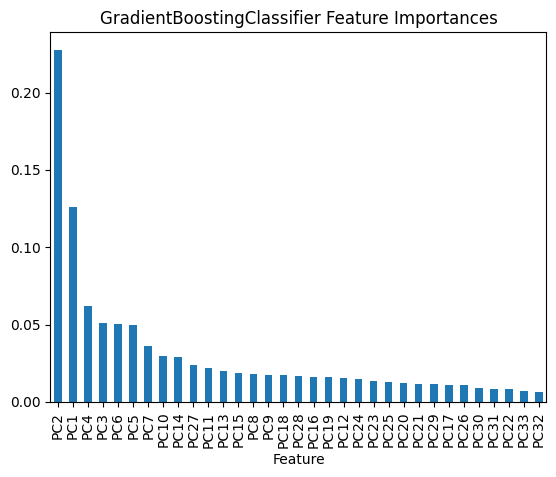

In [51]:
accuracies['Gradient Boosting']=evaluate_classifier(models['Gradient Boosting'], X_train_pca_df,y_train, X_test_pca_df,y_test, X_train_pca_df.columns)

## MLP

In [52]:
accuracies['MLP']=evaluate_classifier(models['MLP'], X_train_pca_df,y_train, X_test_pca_df,y_test)


MLPClassifier Results:
Accuracy: 0.72
Confusion Matrix:
[[14  0  1  0  1  0  2  0  1  1]
 [ 0 12  0  0  0  1  0  0  0  0]
 [ 3  0 17  0  0  1  1  0  2  3]
 [ 2  0  0 13  3  0  1  0  1  1]
 [ 0  0  0  0 11  1  1  1  1  0]
 [ 0  1  0  0  0 19  0  1  0  1]
 [ 0  0  0  1  0  0 22  0  0  2]
 [ 0  0  1  1  0  0  0 11  0  0]
 [ 1  0  3  2  3  0  2  0 11  1]
 [ 0  0  0  3  1  0  0  1  2 14]]
Classification Report:
              precision    recall  f1-score  support
0              0.700000  0.700000  0.700000    20.00
1              0.923077  0.923077  0.923077    13.00
2              0.772727  0.629630  0.693878    27.00
3              0.650000  0.619048  0.634146    21.00
4              0.578947  0.733333  0.647059    15.00
5              0.863636  0.863636  0.863636    22.00
6              0.758621  0.880000  0.814815    25.00
7              0.785714  0.846154  0.814815    13.00
8              0.611111  0.478261  0.536585    23.00
9              0.608696  0.666667  0.636364    21.00
accura

C:\Users\SADEK COMPUTER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# Comparision

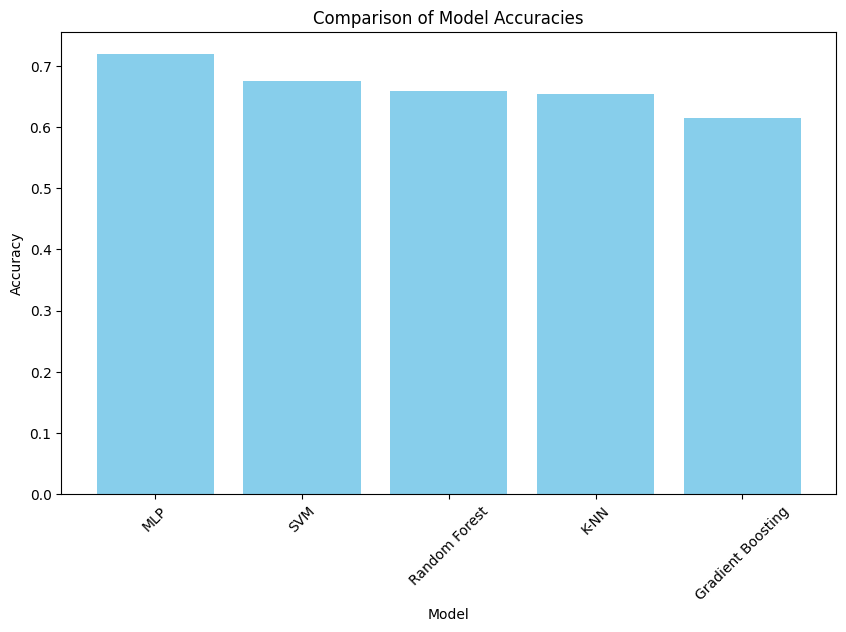

In [53]:
plot_accuracies(accuracies)